In [17]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action="ignore")

In [18]:
RANDOM_STATE = 1
COLUMN_FOR_CLASSIFICATION = "disposition"
CORRELATION_THRESHOLD = 0.9
TEST_SIZE = 0.4

In [19]:
df = pd.read_csv("./k2pandc_2025.10.01_20.09.14.csv")
df.tail()

,rowid,pl_name,hostname,pl_letter,k2_name,epic_hostname,epic_candname,hd_name,hip_name,tic_id,...,releasedate,pl_nnotes,k2_campaigns,k2_campaigns_num,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
3999,4000,WASP-85 A b,WASP-85 A,b,K2-94 b,EPIC 201862715,EPIC 201862715.01,NaN,NaN,TIC 380619414,...,2019-09-05,1,1,1.0,0,0,0,0,0,0
4000,4001,Wolf 503 b,Wolf 503,b,K2-262 b,EPIC 212779563,NaN,NaN,HIP 67285,TIC 187278212,...,2022-05-23,0,17,1.0,1,0,0,0,0,0
4001,4002,Wolf 503 b,Wolf 503,b,K2-262 b,EPIC 212779563,NaN,NaN,HIP 67285,TIC 187278212,...,2018-09-06,0,17,1.0,1,0,0,0,0,0
4002,4003,Wolf 503 b,Wolf 503,b,K2-262 b,EPIC 212779563,NaN,NaN,HIP 67285,TIC 187278212,...,2023-04-17,0,17,1.0,1,0,0,0,0,0
4003,4004,Wolf 503 b,Wolf 503,b,K2-262 b,EPIC 212779563,NaN,NaN,HIP 67285,TIC 187278212,...,2025-08-28,0,17,1.0,1,0,0,0,0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Columns: 295 entries, rowid to pl_ndispec
dtypes: float64(236), int64(26), object(33)
memory usage: 9.0+ MB


In [21]:
df[COLUMN_FOR_CLASSIFICATION] = (
    df[COLUMN_FOR_CLASSIFICATION].astype("category").cat.codes
)
df[COLUMN_FOR_CLASSIFICATION].value_counts()

disposition
1    2315
0    1374
2     293
3      22
Name: count, dtype: int64

In [22]:
# Remove all string columns
df = df.select_dtypes(include=[np.number])

# Remove all columns with null values
df = df.dropna(axis=1)

# Remove identifier columns
df = df.drop(
    columns=[
        "rowid",
        "sy_mnum",
        "cb_flag",
        "pul_flag",
        "ptv_flag",
        "ast_flag",
        "obm_flag",
        "etv_flag",
        "ima_flag",
        "dkin_flag",
        "st_nspec",
        "pl_ndispec",
        "pl_controv_flag",
        "micro_flag",
        "pl_nespec",
        "tran_flag",
        "pl_ntranspec",
        "st_nrvc",
        "st_nphot",
        "ttv_flag",
        "sy_snum",
        *list(df.filter(regex="err$|lim$", axis=1).columns),
    ],
    axis=1,
)

In [23]:
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
)
to_drop = [
    column
    for column in upper_triangle.columns
    if any(upper_triangle[column] > CORRELATION_THRESHOLD)
]
df.drop(to_drop, axis=1, inplace=True)

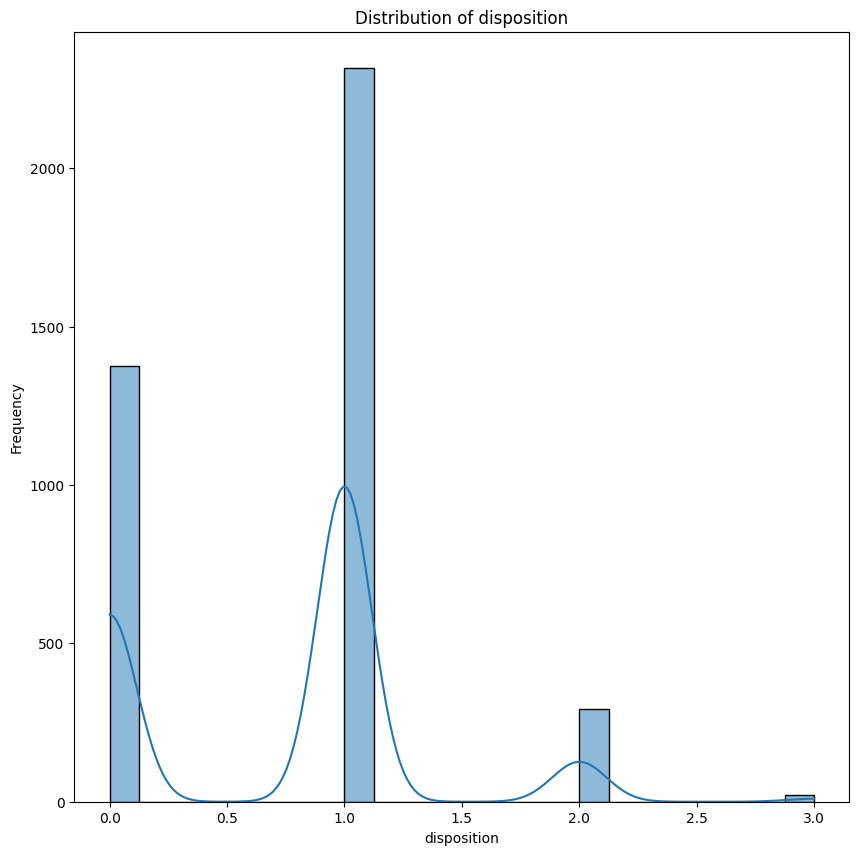

In [24]:
def plot_distribution(df: pd.DataFrame, col: str):
    plt.figure(figsize=(10, 10))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


plot_distribution(df, COLUMN_FOR_CLASSIFICATION)

<Axes: >

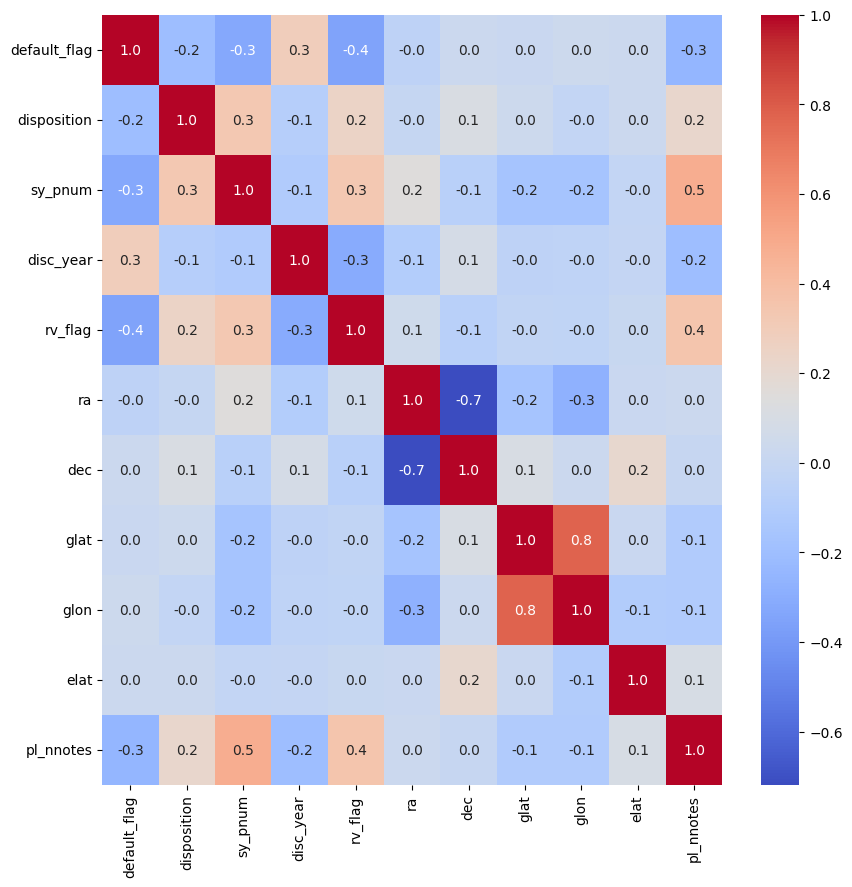

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".1f")

In [26]:
# Check if there are missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [27]:
y = df[COLUMN_FOR_CLASSIFICATION]
X = df.drop(columns=[COLUMN_FOR_CLASSIFICATION], axis=1)

In [28]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
X = pd.DataFrame(imputer.transform(X))

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features)

In [29]:
# Split the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_clf.fit(X_train, y_train)

print(f"Training accuracy: {rf_clf.score(X_train, y_train) * 100:3.2f}%")
print(f"Testing accuracy: {rf_clf.score(X_test, y_test) * 100:3.2f}%")

Training accuracy: 99.95%
Testing accuracy: 95.69%


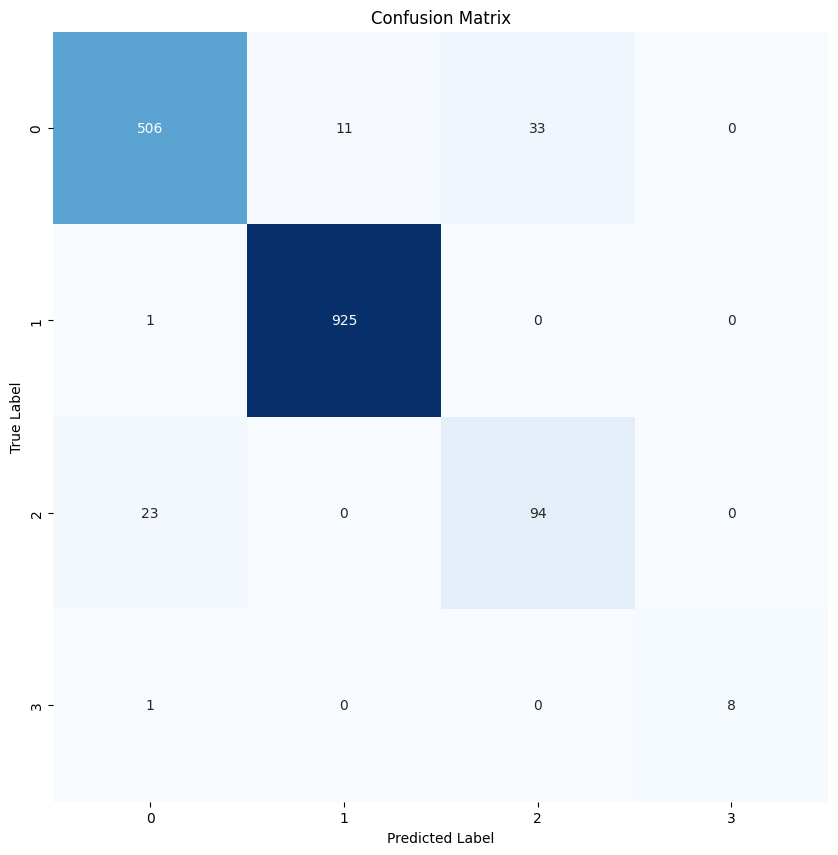

In [31]:
cf_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

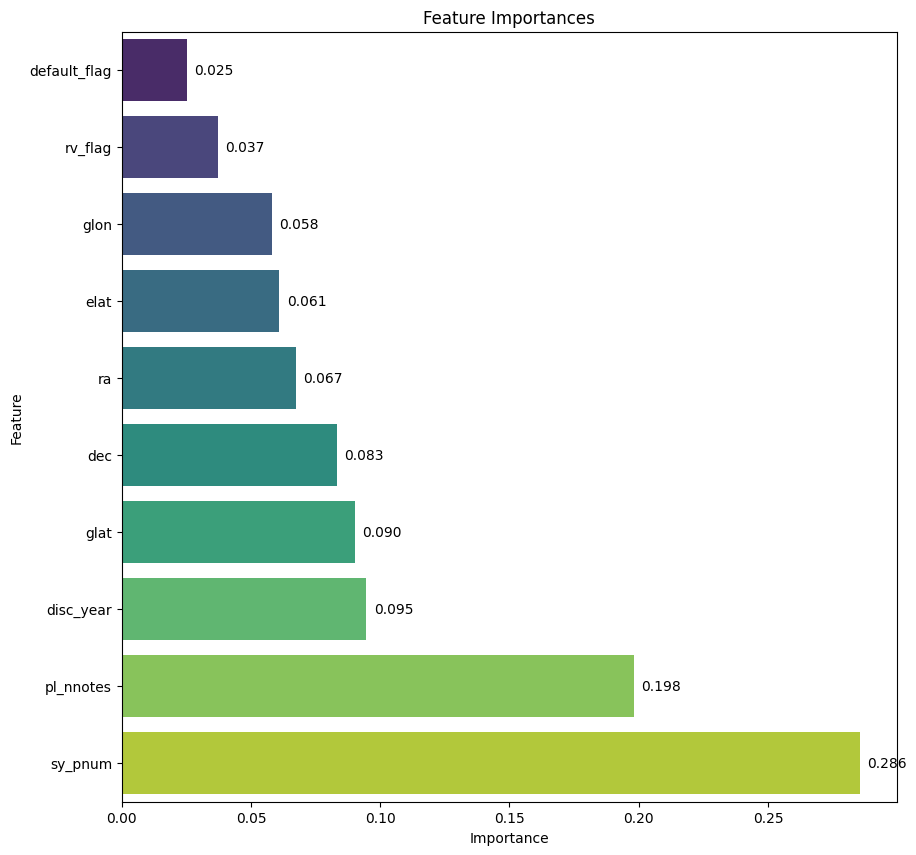

In [32]:
feature_names = df.drop(columns=[COLUMN_FOR_CLASSIFICATION]).columns.tolist()
importances = rf_clf.feature_importances_
feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 10))
ax = sns.barplot(x=feat_series.values, y=feat_series.index, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
for i, v in enumerate(feat_series.values):
    ax.text(v + max(feat_series.values) * 0.01, i, f"{v:.3f}", va="center")

plt.show()